In [134]:
!pip install pmdarima

In [135]:
import pandas as pd
import numpy as np
import requests
import json
from datetime import date
from dateutil.relativedelta import relativedelta
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import xgboost as xgb
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from scipy.stats import boxcox

import warnings
warnings.filterwarnings('ignore')

# **Fetch Unemployment Data From Bureau of Labor Statistics (BLS) Using Public Data API**

In [136]:
# Import or assign API key
ak = "64ff04ec58d44dd1ab4427731c684fc2"

In [137]:
headers = {'Content-type': 'application/json'}

unemploy = pd.DataFrame()

# Fetch the 1st 20years of data
unemploy01 = json.dumps({"seriesid": ['LNS14000000'], "startyear": "1999", "endyear": "2019","registrationkey":ak})
p1 = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=unemploy01, headers=headers)
json_unemploy01 = json.loads(p1.text)

# Fetch the last 5years of data
unemploy02 = json.dumps({"seriesid": ['LNS14000000'], "startyear": "2020", "endyear": "2024","registrationkey":ak})
p2 = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=unemploy02, headers=headers)
json_unemploy02 = json.loads(p2.text)

unemploy_list = [json_unemploy01, json_unemploy02]

for json_data in unemploy_list:
    for series in json_data['Results']['series']:
        seriesId = series['seriesID']
        rows = []
        for item in series['data']:
            year = item['year']
            period = item['period']
            value = item['value']
            footnotes = ""
            for footnote in item['footnotes']:
                if footnote:
                    footnotes = footnotes + footnote['text'] + ','
            if 'M01' <= period <= 'M12':
                rows.append([seriesId, year, period, value, footnotes[0:-1]])
        unemploy_part = pd.DataFrame(rows, columns=["series id", "year", "period", "value", "footnotes"])
        df = pd.concat([unemploy, unemploy_part]).drop(columns=["series id", "footnotes"])

In [138]:
df['period'] = df['period'].map({'M01':'01', 'M02':'02', 'M03':'03', 'M04':'04', 'M05':'05', 'M06':'06', 'M07':'07', 'M08':'08', 'M09':'09',
'M10':'10', 'M11':'11', 'M12':'12'})

In [139]:
df['date'] = pd.to_datetime(df['year'].astype(str) + df['period'] + '01', format='%Y%m%d')
df['UNEMPLOYMENT RATE'] = df['value'].astype(float)
df = df.drop(columns=["period","value","year"],axis=1)
df = df.drop_duplicates(subset=['date'], keep="last").reset_index(drop=True)

In [140]:
df.isnull().any()

date                 False
UNEMPLOYMENT RATE    False
dtype: bool

In [141]:
df.sort_values(by='date',inplace=True)

In [142]:
df.date= pd.to_datetime(df.date)

In [143]:
df.set_index('date',inplace=True)
df.tail()

,UNEMPLOYMENT RATE
date,
2023-12-01,3.7
2024-01-01,3.7
2024-02-01,3.9
2024-03-01,3.8
2024-04-01,3.9


In [144]:
df.head()

,UNEMPLOYMENT RATE
date,
2020-01-01,3.6
2020-02-01,3.5
2020-03-01,4.4
2020-04-01,14.8
2020-05-01,13.2


In [145]:
df['UNEMPLOYMENT RATE'].mean()

5.071153846153846

In [146]:
# decompose_data = seasonal_decompose(df['UNEMPLOYMENT RATE'],model="additive")

In [147]:
# decompose_data.plot()

In [148]:
#Transform original data with log
df_log_scaled = np.log(df)

In [149]:
#subtract the moving average from original data
ma = df.rolling(window=12).mean()
df_minus_ma = df - ma
df_minus_ma.dropna(inplace=True)

In [150]:
#subtract the moving average from log scaled data
ma01 = df_log_scaled.rolling(window=12).mean()
df_log_scaled_minus_ma = df - ma01
df_log_scaled_minus_ma.dropna(inplace=True)

In [151]:
dfCox = df.copy()

In [152]:
# Boxcox Transformation
dfCox['Boxcox'], lam = boxcox(dfCox['UNEMPLOYMENT RATE'])
dfCox["Boxcox_diff"] = dfCox["Boxcox"].diff()
dfCox.drop(['UNEMPLOYMENT RATE', 'Boxcox'], inplace=True, axis=1)
dfCox.dropna(inplace=True)

In [153]:
dfCox.columns

Index(['Boxcox_diff'], dtype='object')

In [154]:
dfCox.head()

,Boxcox_diff
date,
2020-02-01,-0.001214
2020-03-01,0.007788
2020-04-01,0.009681
2020-05-01,-0.000165
2020-06-01,-0.000381


In [155]:
def test_stationarity(data):
  data.dropna(inplace=True)
  rolmean = data.rolling(window=12).mean()
  rolstd = data.rolling(window=12).std()

  orig = plt.plot(data,label="Original")
  mean = plt.plot(rolmean,label="Rolling mean")
  std = plt.plot(rolstd,label="Rolling std")
  plt.legend()

  dftest = adfuller(data)
  dfoutput = pd.Series(dftest[0:4],index=["The test statistics","Mackinnon's approximate p-value","#usedLags","NOBS"])
  print(dfoutput)


  #ACF and PCF for differenced data log scaled - MA
  acf_lag_df_data = acf(data,nlags=20)
  pacf_lag_df_data = pacf(data,nlags=20)

  fig,ax = plt.subplots(1,2,figsize=(15,5))

  plot_acf(acf_lag_df_data,ax=ax[0])
  plot_pacf(pacf_lag_df_data,ax=ax[1])
  plt.show()

  stepwise_fit = auto_arima(data, trace=True,suppress_warnings=True)


The test statistics                -2.917616
Mackinnon's approximate p-value     0.043338
#usedLags                           4.000000
NOBS                               36.000000
dtype: float64


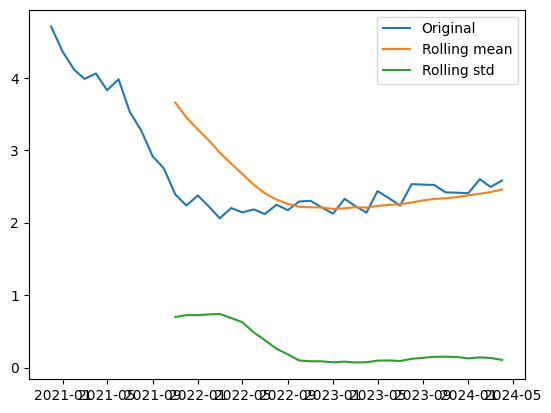

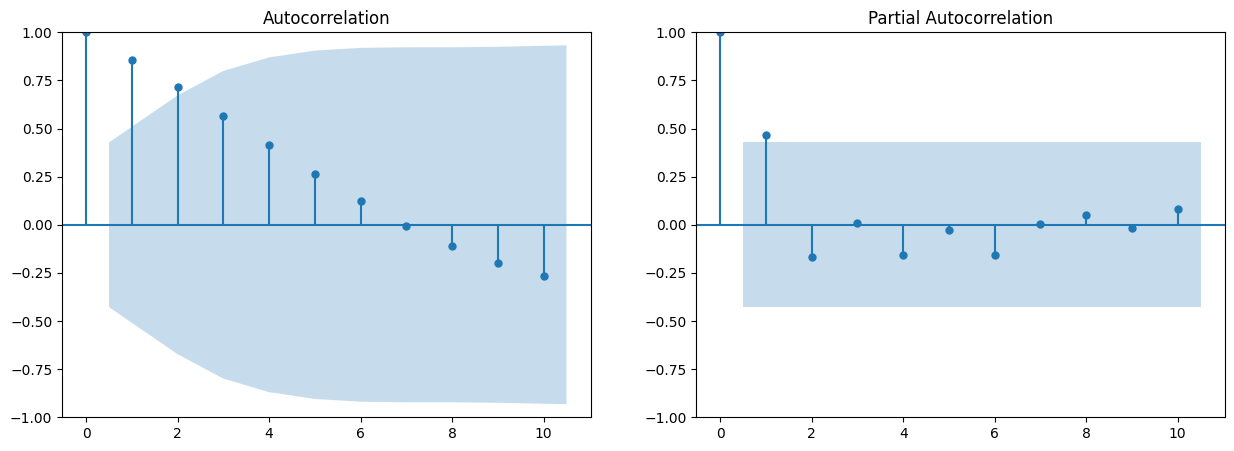

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-19.109, Time=0.62 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=0.768, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-14.395, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-23.093, Time=0.20 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-22.930, Time=0.15 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-22.896, Time=0.24 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-20.983, Time=0.50 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 2.424 seconds


In [156]:
test_stationarity(df_log_scaled_minus_ma)

# Build ModelTo Test the AR, I and MA Parameters

In [157]:
# Split train and test
train_data = df.iloc[:-12]
print('Train size: ', len(train_data))
test_data = df.iloc[-12:]
print('Test size: ',len(test_data))

Train size:  40
Test size:  12


In [158]:
#statsmodels.tsa.ARIMA
my_order = (0,2,1)
model=ARIMA(train_data,order=my_order)
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      UNEMPLOYMENT RATE   No. Observations:                   40
Model:                 ARIMA(0, 2, 1)   Log Likelihood                 -78.044
Date:                Mon, 06 May 2024   AIC                            160.088
Time:                        08:34:01   BIC                            163.363
Sample:                    01-01-2020   HQIC                           161.253
                         - 04-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9989     19.340     -0.052      0.959     -38.904      36.906
sigma2         3.2363     62.503      0.052      0.959    -119.266     125.739
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               286.87
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                             2.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 0, '')

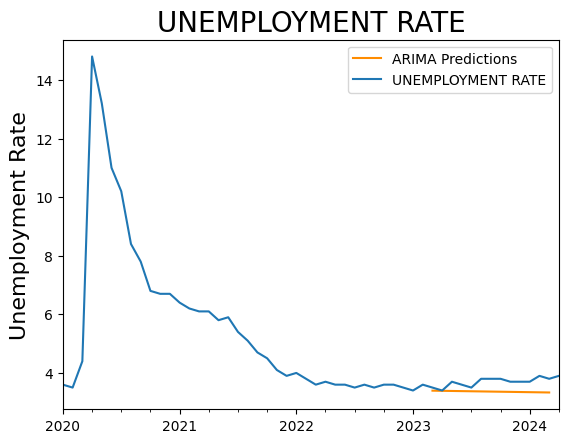

In [159]:
start=len(train_data)
end=len(train_data)+len(test_data)
pred=model.predict(start=start,end=end,type='levels').rename('ARIMA Predictions')
test_date = pd.date_range('2023-03-01', '2024-03-01', freq='MS')
predictions =  pd.DataFrame(pred).set_index(test_date)
Test_df =  pd.DataFrame(test_data)
residuals = test_data['UNEMPLOYMENT RATE'] - predictions['ARIMA Predictions']
#print(residuals)
predictions.plot(legend=True,color='darkorange')
df['UNEMPLOYMENT RATE'].plot(legend=True)
plt.ylabel('Unemployment Rate', fontsize=16)
plt.title('UNEMPLOYMENT RATE', fontsize=20)
plt.xlabel('')

Text(0, 0.5, 'Error')

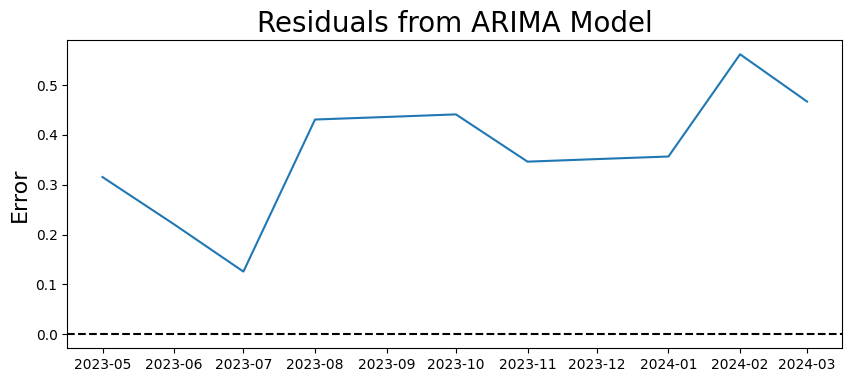

In [160]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from ARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [161]:
print('Mean Absolute Percent Error(%):', round(np.mean(abs(residuals/test_data['UNEMPLOYMENT RATE'] *100)),4))

Mean Absolute Percent Error(%): 9.8065


In [162]:
print('Root Mean Squared Error(%):', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error(%): 0.38600883281463777


# Using the Rolling Forecast Origin

In [163]:
rolling_predictions = test_data.copy()
pred_list = []
for train_end in test_data.index:
  train_data = df[:train_end-timedelta(days=1)]
  model = ARIMA(train_data, order=my_order)
  model_fit = model.fit()

  pred = model_fit.forecast()
  pred_list.append(pred.values)
print(pred)
prediction = pd.DataFrame(pred_list)

2024-04-01    3.803999
Freq: MS, dtype: float64


In [164]:
test_date = pd.date_range('2023-04-01', '2024-03-01', freq='MS')

In [165]:
col2 = ['pred_var']
prediction.columns = col2
prediction.set_index(test_date,inplace=True)

In [166]:
prediction

,pred_var
2023-04-01,3.394847
2023-05-01,3.702500
2023-06-01,3.599978
2023-07-01,3.497619
2023-08-01,3.804648
2023-09-01,3.804544
2023-10-01,3.804444
2023-11-01,3.702173
2023-12-01,3.702125
2024-01-01,3.702074


In [167]:
rolling_residuals = test_data['UNEMPLOYMENT RATE'] - prediction['pred_var']

Text(0, 0.5, 'Error')

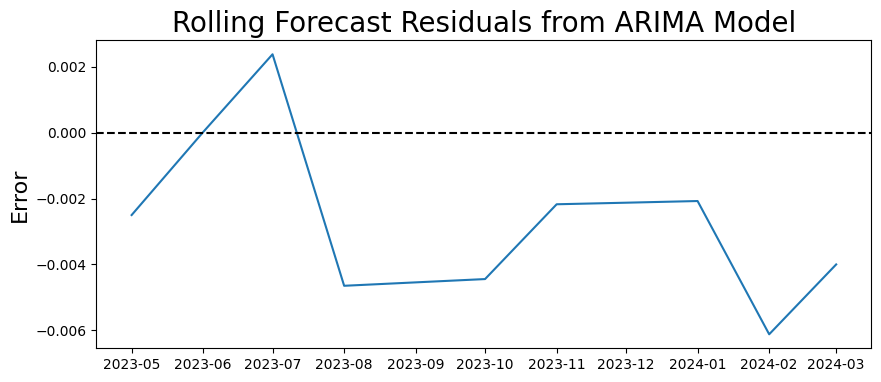

In [168]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from ARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [169]:
start_date = datetime(2023,2,1)
end_date = datetime(2024,1,1)

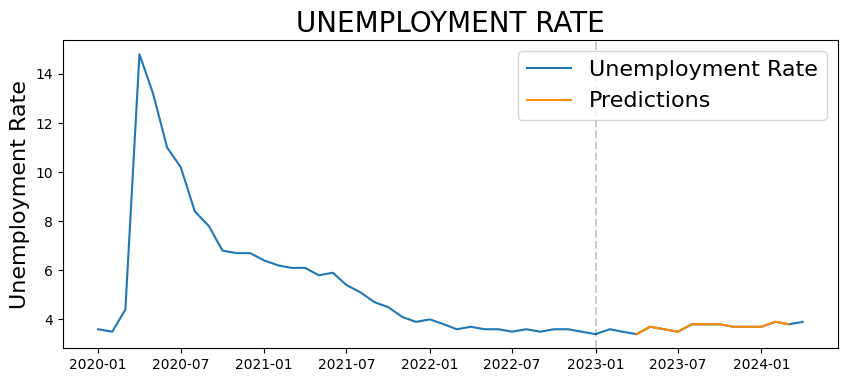

In [170]:
plt.figure(figsize=(10,4))

plt.plot(df)
plt.plot(prediction['pred_var'],color='darkorange')
plt.legend(('Unemployment Rate', 'Predictions'), fontsize=16)
plt.title('UNEMPLOYMENT RATE', fontsize=20)
plt.ylabel('Unemployment Rate', fontsize=16)
for year in range(start_date.year,end_date.year):
  plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [171]:
print('Mean Absolute Percent Error(%):', round(np.mean(abs(rolling_residuals/test_data['UNEMPLOYMENT RATE']*100)),4))

Mean Absolute Percent Error(%): 0.0845


In [172]:
print('Root Mean Squared Error(%):', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error(%): 0.0035789778626815405


# Forecasting The Future

In [173]:
df.index.max()

Timestamp('2024-04-01 00:00:00')

In [174]:
#12 months future projection
future_index = pd.date_range(df.index.max() + relativedelta(months=1),df.index.max() + relativedelta(months=12), freq='MS')


In [175]:
future_index

DatetimeIndex(['2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01',
               '2024-09-01', '2024-10-01', '2024-11-01', '2024-12-01',
               '2025-01-01', '2025-02-01', '2025-03-01', '2025-04-01'],
              dtype='datetime64[ns]', freq='MS')

In [176]:
df_to_predict = pd.DataFrame(index=future_index,columns=df.columns)

In [177]:
#Concatenate Initial dataset and future dataset
df_all = pd.concat([df, df_to_predict], axis=0)
df_all.head()

,UNEMPLOYMENT RATE
2020-01-01,3.6
2020-02-01,3.5
2020-03-01,4.4
2020-04-01,14.8
2020-05-01,13.2


In [178]:
df_all.tail()

,UNEMPLOYMENT RATE
2024-12-01,NaN
2025-01-01,NaN
2025-02-01,NaN
2025-03-01,NaN
2025-04-01,NaN


In [179]:
df_all.shape

(64, 1)

In [180]:
# Split train and test
train_data02 = df_all.iloc[:-24]
print('Train size: ', len(train_data02))
test_data02 = df_all.iloc[-24:]
print('Test size: ',len(test_data02))

Train size:  40
Test size:  24


In [181]:
pred_list02 = []
for train_end in test_data02.index:
  train_data02 = df_all[:train_end-timedelta(days=1)]
  model02 = ARIMA(train_data02, order=my_order)
  model_fit = model02.fit()

  pred02 = model_fit.forecast()
  pred_list02.append(pred02.values)

prediction02 = pd.DataFrame(pred_list02)

In [182]:
col02 = ['pred_var']
prediction02.columns = col02
prediction02.set_index(test_data02.index,inplace=True)

In [183]:
prediction02

,pred_var
2023-05-01,3.394847
2023-06-01,3.702500
2023-07-01,3.599978
2023-08-01,3.497619
2023-09-01,3.804648
2023-10-01,3.804544
2023-11-01,3.804444
2023-12-01,3.702173
2024-01-01,3.702125
2024-02-01,3.702074


In [184]:
start_date = datetime(2023,2,1)
end_date = datetime(2024,4,1)

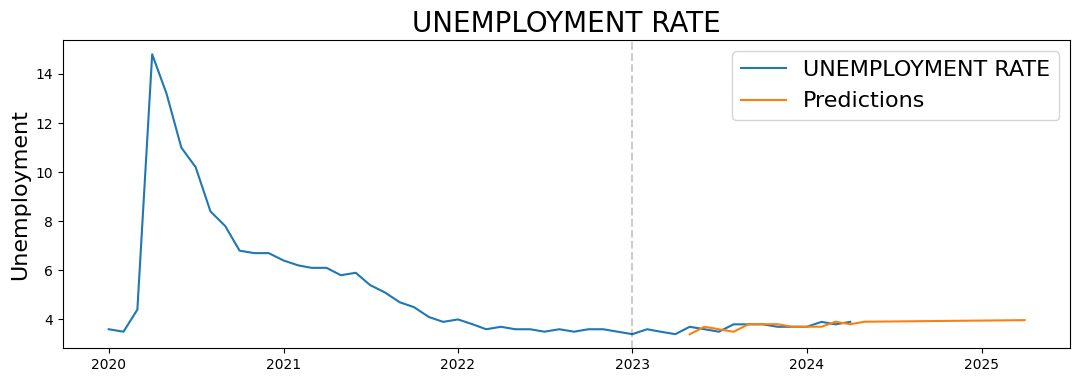

In [185]:
plt.figure(figsize=(13,4))

plt.plot(df_all)
plt.plot(prediction02['pred_var'])
plt.legend(('UNEMPLOYMENT RATE', 'Predictions'), fontsize=16)
plt.title('UNEMPLOYMENT RATE', fontsize=20)
plt.ylabel('Unemployment', fontsize=16)
for year in range(start_date.year,end_date.year):
  plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)